## Mount the google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Unzip the dataset

In [ ]:
!unzip -q '/content/drive/MyDrive/02 - CNN-Cards/Datasets/Cards.zip' -d '/content/sample_data/Datasets'

In [ ]:
DATA_PATH = '/content/sample_data/Datasets/'
DRIVE_PATH = '/content/drive/MyDrive/Colab Notebooks/Computer Vision course/DL/02 - CNN-Cards/'

## Import libraries

In [ ]:
!pip install tensorflow-addons --quiet
!pip install vit-keras --quiet
!pip install tensorflow==2.10 --quiet
!pip install tensorflow-addons --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 7.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.4.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.0/578.0 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 68.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 57.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 101.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 31.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 87.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import tensorflow as tf
from vit_keras import vit
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

# Global variables
SIZE = 224    # Dimensions of the images
CLASSES = 53  # Number of categories
EPOCHS = 75
PATIENCE_ES = 20

path_models = DRIVE_PATH+r'Models'

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.13.0 and strictly below 2.16.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're u

In [ ]:
print(tf.__version__)

print(tf.test.gpu_device_name())

if tf.test.is_built_with_gpu_support():
    print('Se detectó una GPU')
else:
    print('No se detectó una GPU')

2.10.0

Se detectó una GPU


In [ ]:
!nvidia-smi

Tue Dec 10 18:31:34 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P0              28W /  70W |    103MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Load pre-trained models

In [ ]:
# Download pre-trained models without the Top
MobileNet = tf.keras.applications.MobileNetV2(include_top=False, weights='imagenet', input_shape=(SIZE,SIZE,3))
vitB16 = vit.vit_b16(image_size= SIZE, include_top=False, pretrained_top=False, pretrained=True)

vitB16.trainable = False
MobileNet.trainable = False

347502902/347502902 [==============================] - 1s 0us/step


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


In [ ]:
# Summary of the model
MobileNet.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[

API Sequential: Una forma sencilla y lineal de apilar capas.

Limitaciones:

*   No permite modelos con múltiples entradas o salidas
*  No admite capas compartidas o conexiones no lineales
*   No es adecuada para arquitecturas donde se necesitan saltos o conexiones entre capas no adyacentes.


API Funcional: Una forma más flexible que permite construir modelos complejos con arquitecturas personalizadas.

## Build model in Sequential API

In [ ]:
# Build models based on the pre-trained with the Sequential API

# creation as a list of layers
mn_sq = tf.keras.Sequential([
    MobileNet,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(CLASSES, activation='softmax')
                                ])
transformer_sq = tf.keras.Sequential([
    vitB16,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(CLASSES, activation='softmax')
                                ])
# Creation by adding layers
model_sq = tf.keras.Sequential()
model_sq.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(224,224,3)))
model_sq.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model_sq.add(tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model_sq.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model_sq.add(tf.keras.layers.Flatten())
model_sq.add(tf.keras.layers.Dense(128, activation='relu'))
model_sq.add(tf.keras.layers.Dense(64, activation='relu'))
model_sq.add(tf.keras.layers.Dense(CLASSES, activation='softmax'))

In [ ]:
# Summary of the model
mn_sq.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 flatten (Flatten)           (None, 62720)             0         
                                                                 
 dense (Dense)               (None, 128)               8028288   
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 53)                3445      
                                                                 
Total params: 10297973 (39.28 MB)
Trainable params: 8039989 (30.67 MB)
Non-trainable params: 2257984 (8.61 MB)
___________

In [ ]:
# Summary of the model
transformer_sq.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b16 (Functional)        (None, 768)               85798656  
                                                                 
 flatten_1 (Flatten)         (None, 768)               0         
                                                                 
 dense_3 (Dense)             (None, 128)               98432     
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 53)                3445      
                                                                 
Total params: 85908789 (327.72 MB)
Trainable params: 110133 (430.21 KB)
Non-trainable params: 85798656 (327.30 MB)
_________________________________________________________________


In [ ]:
# Summary of the model
model_sq.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 186624)            0         
                                                                 
 dense_6 (Dense)             (None, 128)              

## Build model in Functional API

In [ ]:
# Build models based on the pre-trained with the Functional API

inputy = tf.keras.layers.Input(shape=(SIZE,SIZE,3))
y = MobileNet(inputy)
y = tf.keras.layers.Flatten()(y)
y = tf.keras.layers.Dense(128, activation='relu')(y)
y = tf.keras.layers.Dense(64, activation='relu')(y)
outputy = tf.keras.layers.Dense(CLASSES, activation='softmax')(y)

mn_fc = tf.keras.Model(inputs=inputy, outputs=outputy)

#########################################################################################

input = tf.keras.layers.Input(shape=(SIZE,SIZE,3))  # Declare input layer
x = vitB16(input)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
output = tf.keras.layers.Dense(CLASSES, activation='softmax')(x)

transformer_fc = tf.keras.Model(inputs=input, outputs=output)  # Build the model

#########################################################################################

inputc = tf.keras.layers.Input(shape=(SIZE,SIZE,3))
y = tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(224,224,3))(inputc)
y = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(y)
y = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu')(y)
y = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(y)
y = tf.keras.layers.Flatten()(y)
y = tf.keras.layers.Dense(128, activation='relu')(y)
y = tf.keras.layers.Dense(64, activation='relu')(y)
outputc = tf.keras.layers.Dense(CLASSES, activation='softmax')(y)

model_fc = tf.keras.Model(inputs=inputc, outputs=outputc)

In [ ]:
# Summary of the model
mn_fc.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 flatten_3 (Flatten)         (None, 62720)             0         
                                                                 
 dense_9 (Dense)             (None, 128)               8028288   
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                                 
 dense_11 (Dense)            (None, 53)                3445      
                                                             

## Compare models

In [ ]:
# Number of parameters comparision
# Convolutional transfer learning
trainable_params_cfc = np.sum([np.prod(variable.shape) for variable in mn_fc.trainable_variables])
non_trainable_params_cfc = np.sum([np.prod(variable.shape) for variable in mn_fc.non_trainable_variables])

trainable_params_csq = np.sum([np.prod(variable.shape) for variable in mn_sq.trainable_variables])
non_trainable_params_csq = np.sum([np.prod(variable.shape) for variable in mn_sq.non_trainable_variables])

if (trainable_params_cfc == trainable_params_csq) and (non_trainable_params_cfc==non_trainable_params_csq):
  print('MobileNet model OK')

# Transformer architecture
trainable_params_tfc = np.sum([np.prod(variable.shape) for variable in transformer_fc.trainable_variables])
non_trainable_params_tfc = np.sum([np.prod(variable.shape) for variable in transformer_fc.non_trainable_variables])

trainable_params_tsq = np.sum([np.prod(variable.shape) for variable in transformer_sq.trainable_variables])
non_trainable_params_tsq = np.sum([np.prod(variable.shape) for variable in transformer_sq.non_trainable_variables])

if (trainable_params_tfc == trainable_params_tsq) and (non_trainable_params_tfc==non_trainable_params_tsq):
  print('Transformer model OK')

# Custom convolutional model
trainable_params_customfc = np.sum([np.prod(variable.shape) for variable in model_fc.trainable_variables])
non_trainable_params_customfc = np.sum([np.prod(variable.shape) for variable in model_fc.non_trainable_variables])

trainable_params_customsq = np.sum([np.prod(variable.shape) for variable in model_sq.trainable_variables])
non_trainable_params_customsq = np.sum([np.prod(variable.shape) for variable in model_sq.non_trainable_variables])

if (trainable_params_customfc == trainable_params_customsq) and (non_trainable_params_customfc==non_trainable_params_customsq):
  print('Convolutional model OK')

MobileNet model OK
Transformer model OK
Convolutional model OK


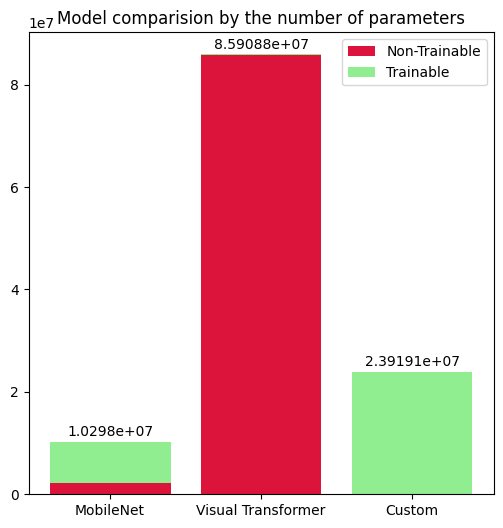

In [ ]:
fig = plt.figure(figsize=(6,6))

axis_x = ['MobileNet', 'Visual Transformer', 'Custom']

ax = plt.subplot(1, 1, 1)
ax.bar(axis_x, [non_trainable_params_cfc, non_trainable_params_tfc, non_trainable_params_customfc], color='crimson', label='Non-Trainable')
b = ax.bar(axis_x, [trainable_params_cfc, trainable_params_tfc, trainable_params_customfc], bottom= [non_trainable_params_cfc, non_trainable_params_tfc, non_trainable_params_customfc], color='lightgreen', label='Trainable')
ax.bar_label(b, padding= 2)
ax.set_title('Model comparision by the number of parameters')
ax.legend(loc = 'upper right')
plt.show()

Despite the overall size of the model, the Transformer-based architecture has a very low number of trainable parameters.

## Load data

### Image data generator

In [ ]:
# Image generator from TensorFlow (https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)

train_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale= 1.0/255,
                                                                  rotation_range=10,
                                                                  horizontal_flip=True)

valid_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale= 1.0/255)
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale= 1.0/255)

### Flow from directory method

In [ ]:
# Build the datasets with flow from directory method from ImageDataGenerator object

train_path = DATA_PATH + 'train'
valid_path = DATA_PATH + 'valid'
test_path = DATA_PATH + 'test'

# Path to the directory
# Define sizes
# Declare classes as categorical
# Batch size = 16
# Train dataset should always have shuffle
train_dataset_ffd = train_generator.flow_from_directory(
    train_path,
    target_size= (SIZE,SIZE),
    class_mode= 'categorical',
    batch_size= 64,
    shuffle= True
                                                        )

# Valid and Test dataset don't need to be shuffled
valid_dataset_ffd = valid_generator.flow_from_directory(
    valid_path,
    target_size= (SIZE,SIZE),
    class_mode= 'categorical',
    batch_size= 64,
    shuffle= False
                                                        )

test_dataset_ffd = test_generator.flow_from_directory(
    test_path,
    target_size= (SIZE,SIZE),
    class_mode= 'categorical',
    batch_size= 64,
    shuffle= False
                                                        )

Found 7624 images belonging to 53 classes.
Found 265 images belonging to 53 classes.
Found 265 images belonging to 53 classes.


## Train models

### MobileNet

In [ ]:
# Callbacks definitions for training
# Save the best model at the end of each epoch (if is better than the saved one)
# Stop training if the model is not improving after 20 epochs

name = 'MobileNet'

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    os.path.join(path_models, name + '.h5'),
    monitor= 'val_accuracy',
    verbose= 0,
    save_best_only= True,
    save_weights_only= False,
    mode= 'max',
    save_freq= 'epoch')

stop = tf.keras.callbacks.EarlyStopping(
    monitor= 'val_accuracy',
    min_delta= 0.01,
    patience= PATIENCE_ES,
    verbose = 0,
    mode= 'max',
    baseline= None,
    restore_best_weights= True)

In [ ]:
# Model compilation
mn_sq.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
def plot_and_save(h, dir, name):

  history = pd.DataFrame(h.history)

  history['epoch'] = list(range(0,len(history.index)))

  history.to_csv(os.path.join(dir, name+'.csv'), header=True, index=False)

  # Plot history: CE
  plt.figure()
  plt.plot(history['epoch'], history['loss'], label='Loss (training data)')
  plt.plot(history['epoch'], history['val_loss'], label='Loss (validation data)')
  plt.title('Loss')
  plt.ylabel('CE')
  plt.xlabel('Nº epoch')
  plt.legend(loc="upper left")
  plt.show()

  # Plot history: Accuracy
  plt.figure()
  plt.plot(history['epoch'], history['accuracy'], label='Accuracy (training data)')
  plt.plot(history['epoch'], history['val_accuracy'], label='Accuracy (validation data)')
  plt.title('Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Nº epoch')
  plt.legend(loc="upper left")
  plt.show()

In [ ]:
EPOCHS = 25
h = mn_sq.fit(train_dataset_ffd, validation_data=valid_dataset_ffd, epochs=EPOCHS, callbacks=[checkpoint, stop])

Epoch 1/25
120/120 [==============================] - 88s 734ms/step - loss: 1.4271 - accuracy: 0.5959 - val_loss: 1.6624 - val_accuracy: 0.4943
Epoch 2/25
120/120 [==============================] - ETA: 0s - loss: 1.1751 - accuracy: 0.6594

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


120/120 [==============================] - 87s 727ms/step - loss: 1.1751 - accuracy: 0.6594 - val_loss: 1.3676 - val_accuracy: 0.5962
Epoch 3/25
120/120 [==============================] - 86s 717ms/step - loss: 0.9518 - accuracy: 0.7194 - val_loss: 1.4627 - val_accuracy: 0.5660
Epoch 4/25
120/120 [==============================] - 89s 739ms/step - loss: 0.8238 - accuracy: 0.7552 - val_loss: 1.4180 - val_accuracy: 0.5962
Epoch 5/25
120/120 [==============================] - 89s 742ms/step - loss: 0.6680 - accuracy: 0.7991 - val_loss: 1.5245 - val_accuracy: 0.5811
Epoch 6/25
120/120 [==============================] - 89s 741ms/step - loss: 0.5951 - accuracy: 0.8199 - val_loss: 1.5416 - val_accuracy: 0.5962
Epoch 7/25
120/120 [==============================] - 90s 748ms/step - loss: 0.4963 - accuracy: 0.8496 - val_loss: 1.4839 - val_accuracy: 0.6302
Epoch 8/25
120/120 [==============================] - 88s 733ms/step - loss: 0.4395 - accuracy: 0.8641 - val_loss: 1.6902 - val_accuracy: 0.5

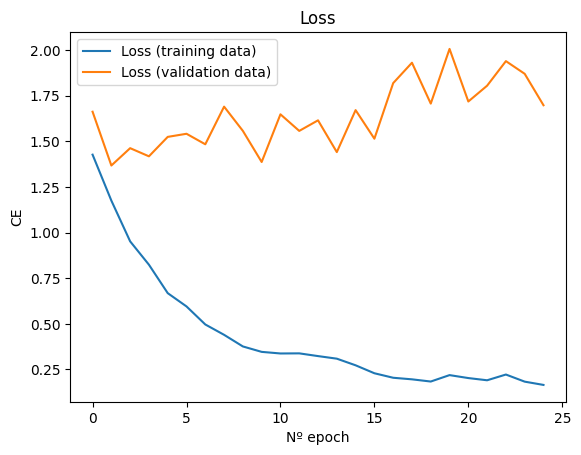

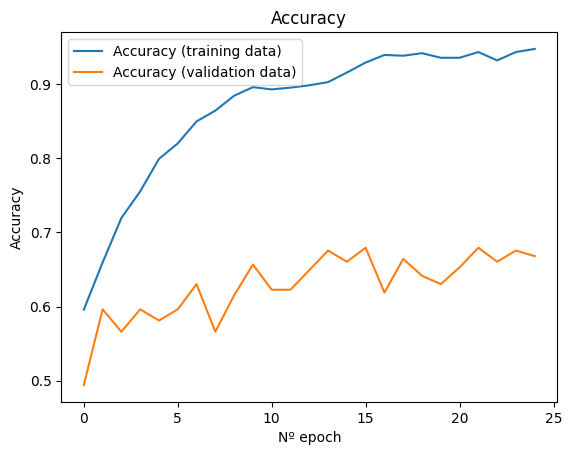

In [ ]:
plot_and_save(h, path_csv, name)

This model is overfitted, data augmentation in training data is required

### Visual Transformer

In [ ]:
# Callbacks definitions for training
# Save the best model at the end of each epoch (if is better than the saved one)
# Stop training if the model is not improving after 20 epochs

name = 'ViT_B16'

checkpointv = tf.keras.callbacks.ModelCheckpoint(
    os.path.join(path_models, name + '.h5'),
    monitor= 'val_accuracy',
    verbose= 0,
    save_best_only= True,
    save_weights_only= False,
    mode= 'max',
    save_freq= 'epoch'
                                                )

stopv = tf.keras.callbacks.EarlyStopping(
    monitor= 'val_accuracy',
    min_delta= 0.01,
    patience= PATIENCE_ES,
    verbose = 0,
    mode= 'max',
    baseline= None,
    restore_best_weights= True
                                                )

In [ ]:
# Model compilation
transformer_sq.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
h = transformer_sq.fit(train_dataset_ffd, validation_data=valid_dataset_ffd, epochs=EPOCHS, callbacks=[checkpointv, stopv])

In [ ]:
plot_and_save(h, path_csv, name)

This model is overfitted, and also needs more trainable parameters

### Custom

In [ ]:
# Compile the model
model_sq.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Callbacks definitions for training
# Save the best model at the end of each epoch (if is better than the saved one)
# Stop training if the model is not improving after 20 epochs

name = 'Custom'

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    os.path.join(path_models, name + '.h5'),
    monitor= 'val_accuracy',
    verbose= 0,
    save_best_only= True,
    save_weights_only= False,
    mode= 'max',
    save_freq= 'epoch'
                                                )

stop = tf.keras.callbacks.EarlyStopping(
    monitor= 'val_accuracy',
    min_delta= 0.01,
    patience= PATIENCE_ES,
    verbose = 0,
    mode= 'max',
    baseline= None,
    restore_best_weights= True
                                                )

h = model_sq.fit(train_dataset_ffd, validation_data=valid_dataset_ffd, epochs=EPOCHS, callbacks=[checkpoint, stop])

In [ ]:
plot_and_save(h, path_csv, name)

This model is overfitted

## Fine tuning train

### MobileNet, data augmentation in training data is implemented, number of trainable weights is higher

In [ ]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale= 1.0/255,
                                                                  rotation_range=15,
                                                                  horizontal_flip=True,
                                                                  vertical_flip=True,
                                                                  zoom_range=0.1,
                                                                  fill_mode='reflect')


valid_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale= 1.0/255)
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale= 1.0/255)

train_path = DATA_PATH + 'train'
valid_path = DATA_PATH + 'valid'
test_path = DATA_PATH + 'test'

# Path to the directory
# Define sizes
# Declare classes as categorical
# Batch size = 16
# Train dataset should always have shuffle
train_dataset_ffd = train_generator.flow_from_directory(
    train_path,
    target_size= (SIZE,SIZE),
    class_mode= 'categorical',
    batch_size= 64,
    shuffle= True
                                                        )

# Valid and Test dataset don't need to be shuffled
valid_dataset_ffd = valid_generator.flow_from_directory(
    valid_path,
    target_size= (SIZE,SIZE),
    class_mode= 'categorical',
    batch_size= 64,
    shuffle= False
                                                        )

test_dataset_ffd = test_generator.flow_from_directory(
    test_path,
    target_size= (SIZE,SIZE),
    class_mode= 'categorical',
    batch_size= 64,
    shuffle= False
                                                        )

Found 7624 images belonging to 53 classes.
Found 265 images belonging to 53 classes.
Found 265 images belonging to 53 classes.


In [ ]:
name = 'MobileNet_2'

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    os.path.join(path_models, name + '.h5'),
    monitor= 'val_accuracy',
    verbose= 0,
    save_best_only= True,
    save_weights_only= False,
    mode= 'max',
    save_freq= 'epoch'
                                                )

stop = tf.keras.callbacks.EarlyStopping(
    monitor= 'val_accuracy',
    min_delta= 0.001,
    patience= PATIENCE_ES,
    verbose = 0,
    mode= 'max',
    baseline= None,
    restore_best_weights= True
                                                )

In [ ]:
mn_train_1 = tf.keras.models.load_model(DATA_PATH+'Models/MobileNet.h5')
weights = mn_train_1.get_weights()

base_net = tf.keras.applications.MobileNetV2(include_top=False, weights='imagenet', input_shape=(SIZE,SIZE,3))

# by default, layers are trainable
# MobileNet has 154 layers
# Freezing 130, rougthly 60% trainable parameters
for layer in base_net.layers[:130]:
    layer.trainable = False

mn_ft = tf.keras.Sequential([
    base_net,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(CLASSES, activation='softmax')])

Epoch 1/100
477/477 [==============================] - 53s 107ms/step - loss: 4.0059 - accuracy: 0.0888 - val_loss: 9.9629 - val_accuracy: 0.0717
Epoch 2/100
477/477 [==============================] - 51s 107ms/step - loss: 2.9654 - accuracy: 0.2496 - val_loss: 5.0736 - val_accuracy: 0.2453
Epoch 3/100
477/477 [==============================] - 52s 108ms/step - loss: 2.3451 - accuracy: 0.4035 - val_loss: 3.0866 - val_accuracy: 0.3811
Epoch 4/100
477/477 [==============================] - 53s 110ms/step - loss: 2.1175 - accuracy: 0.4520 - val_loss: 2.1674 - val_accuracy: 0.4642
Epoch 5/100
477/477 [==============================] - 51s 107ms/step - loss: 1.9157 - accuracy: 0.4860 - val_loss: 1.7024 - val_accuracy: 0.5849
Epoch 6/100
477/477 [==============================] - 50s 105ms/step - loss: 1.7483 - accuracy: 0.5269 - val_loss: 2.1912 - val_accuracy: 0.5019
Epoch 7/100
477/477 [==============================] - 49s 103ms/step - loss: 1.6666 - accuracy: 0.5471 - val_loss: 2.0905 -

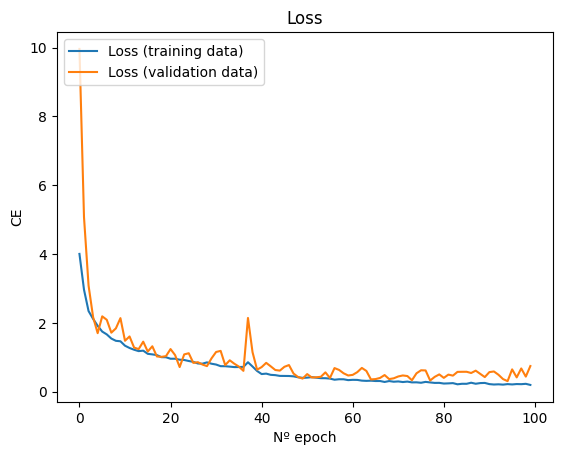

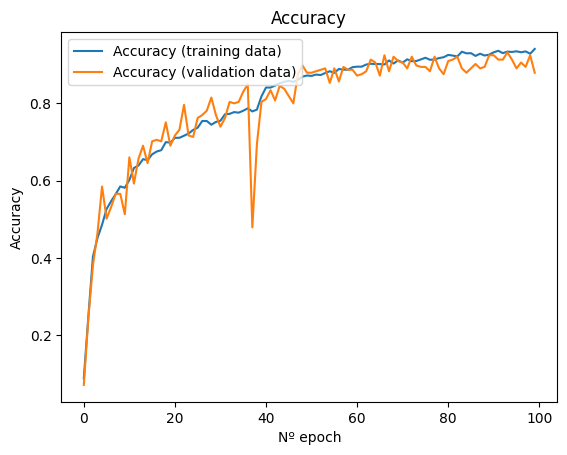

In [ ]:
EPOCHS=100
mn_ft.set_weights(weights)

mn_ft.compile(optimizer= 'adam', loss='categorical_crossentropy', metrics=['accuracy'])
h = mn_ft.fit(train_dataset_ffd, validation_data=valid_dataset_ffd, epochs=EPOCHS, callbacks=[checkpoint, stop])

plot_and_save(h, path_csv, name)

### ViT, data augmentation in training is implemented, number of trainable weights is higher

In [ ]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale= 1.0/255,
                                                                  rotation_range=20,
                                                                  horizontal_flip=True,
                                                                  vertical_flip=True,
                                                                  zoom_range=0.1,
                                                                  fill_mode='reflect')


valid_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale= 1.0/255)
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale= 1.0/255)

train_path = DATA_PATH + 'train'
valid_path = DATA_PATH + 'valid'
test_path = DATA_PATH + 'test'

# Path to the directory
# Define sizes
# Declare classes as categorical
# Batch size = 16
# Train dataset should always have shuffle
train_dataset_ffd = train_generator.flow_from_directory(
    train_path,
    target_size= (SIZE,SIZE),
    class_mode= 'categorical',
    batch_size= 64,
    shuffle= True
                                                        )

# Valid and Test dataset don't need to be shuffled
valid_dataset_ffd = valid_generator.flow_from_directory(
    valid_path,
    target_size= (SIZE,SIZE),
    class_mode= 'categorical',
    batch_size= 64,
    shuffle= False
                                                        )

test_dataset_ffd = test_generator.flow_from_directory(
    test_path,
    target_size= (SIZE,SIZE),
    class_mode= 'categorical',
    batch_size= 64,
    shuffle= False
                                                        )

Found 7624 images belonging to 53 classes.
Found 265 images belonging to 53 classes.
Found 265 images belonging to 53 classes.


In [ ]:
name = 'ViT_B16_2'

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    os.path.join(path_models, name + '.h5'),
    monitor= 'val_accuracy',
    verbose= 0,
    save_best_only= True,
    save_weights_only= False,
    mode= 'max',
    save_freq= 'epoch'
                                                )

stop = tf.keras.callbacks.EarlyStopping(
    monitor= 'val_accuracy',
    min_delta= 0.001,
    patience= PATIENCE_ES,
    verbose = 0,
    mode= 'max',
    baseline= None,
    restore_best_weights= True
                                                )

In [ ]:
transformer_train_1 = tf.keras.models.load_model(DATA_PATH+'Models/ViT_B16.h5')
weights = transformer_train_1.get_weights()

# the pretrained is similar to weigths="imagenet"
base_net = vit.vit_b16(image_size= SIZE, include_top=False, pretrained_top=False, pretrained=True)

# by default, layers are trainable
# ViT has 19 layers
# Freezing 10, rougthly 60% trainable parameters
for layer in base_net.layers[:10]:
    layer.trainable = False

transformer_ft = tf.keras.Sequential([
    base_net,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(CLASSES, activation='softmax')])

c:\Users\faricardo\Anaconda3\envs\tecnun_mia\lib\site-packages\vit_keras\utils.py:83: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  UserWarning,


Epoch 1/100
477/477 [==============================] - 80s 150ms/step - loss: 2.0730 - accuracy: 0.3885 - val_loss: 1.0049 - val_accuracy: 0.6453
Epoch 2/100
477/477 [==============================] - 70s 146ms/step - loss: 1.1514 - accuracy: 0.6360 - val_loss: 0.8238 - val_accuracy: 0.7057
Epoch 3/100
477/477 [==============================] - 70s 147ms/step - loss: 0.9320 - accuracy: 0.7037 - val_loss: 0.9530 - val_accuracy: 0.7132
Epoch 4/100
477/477 [==============================] - 71s 148ms/step - loss: 0.8380 - accuracy: 0.7331 - val_loss: 0.6250 - val_accuracy: 0.8075
Epoch 5/100
477/477 [==============================] - 71s 148ms/step - loss: 0.7684 - accuracy: 0.7619 - val_loss: 0.5927 - val_accuracy: 0.8151
Epoch 6/100
477/477 [==============================] - 69s 145ms/step - loss: 0.7269 - accuracy: 0.7690 - val_loss: 0.6766 - val_accuracy: 0.8075
Epoch 7/100
477/477 [==============================] - 71s 149ms/step - loss: 0.7345 - accuracy: 0.7723 - val_loss: 0.4581 -

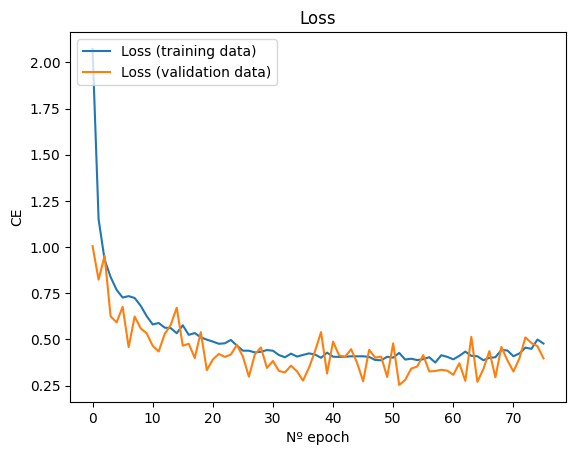

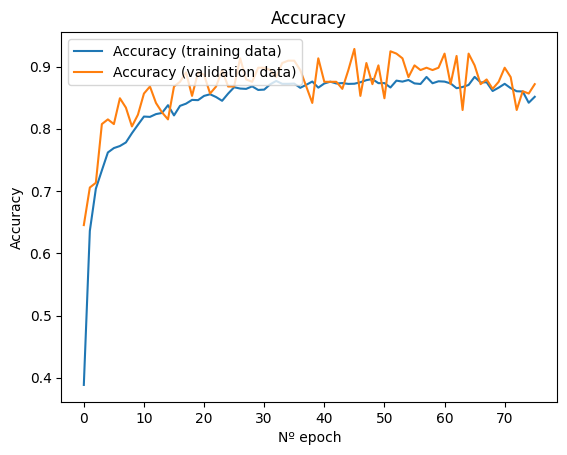

In [ ]:
transformer_ft.set_weights(weights)

transformer_ft.compile(optimizer= 'adam', loss='categorical_crossentropy', metrics=['accuracy'])
h = transformer_ft.fit(train_dataset_ffd, validation_data=valid_dataset_ffd, epochs=EPOCHS, callbacks=[checkpoint, stop])

plot_and_save(h, path_csv, name)

### Custom, data augmentation in training is implemented

In [ ]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale= 1.0/255,
                                                                  rotation_range=15,
                                                                  horizontal_flip=True,
                                                                  vertical_flip=True,
                                                                  zoom_range=0.1,
                                                                  fill_mode='reflect')


valid_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale= 1.0/255)
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale= 1.0/255)

train_path = DATA_PATH + 'train'
valid_path = DATA_PATH + 'valid'
test_path = DATA_PATH + 'test'

# Path to the directory
# Define sizes
# Declare classes as categorical
# Batch size = 16
# Train dataset should always have shuffle
train_dataset_ffd = train_generator.flow_from_directory(
    train_path,
    target_size= (SIZE,SIZE),
    class_mode= 'categorical',
    batch_size= 64,
    shuffle= True
                                                        )

# Valid and Test dataset don't need to be shuffled
valid_dataset_ffd = valid_generator.flow_from_directory(
    valid_path,
    target_size= (SIZE,SIZE),
    class_mode= 'categorical',
    batch_size= 64,
    shuffle= False
                                                        )

test_dataset_ffd = test_generator.flow_from_directory(
    test_path,
    target_size= (SIZE,SIZE),
    class_mode= 'categorical',
    batch_size= 64,
    shuffle= False
                                                        )

Found 7624 images belonging to 53 classes.
Found 265 images belonging to 53 classes.
Found 265 images belonging to 53 classes.


In [ ]:
name = 'Custom_2'

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    os.path.join(path_models, name + '.h5'),
    monitor= 'val_accuracy',
    verbose= 0,
    save_best_only= True,
    save_weights_only= False,
    mode= 'max',
    save_freq= 'epoch'
                                                )

stop = tf.keras.callbacks.EarlyStopping(
    monitor= 'val_accuracy',
    min_delta= 0.001,
    patience= PATIENCE_ES,
    verbose = 0,
    mode= 'max',
    baseline= None,
    restore_best_weights= True
                                                )

In [ ]:
model_ft = tf.keras.models.load_model('Models/Custom.h5')

Epoch 1/100
477/477 [==============================] - 54s 113ms/step - loss: 1.3178 - accuracy: 0.6898 - val_loss: 1.1278 - val_accuracy: 0.7358
Epoch 2/100
477/477 [==============================] - 52s 108ms/step - loss: 1.0721 - accuracy: 0.7331 - val_loss: 1.2688 - val_accuracy: 0.6717
Epoch 3/100
477/477 [==============================] - 50s 106ms/step - loss: 1.0038 - accuracy: 0.7385 - val_loss: 1.1837 - val_accuracy: 0.6906
Epoch 4/100
477/477 [==============================] - 50s 105ms/step - loss: 0.9338 - accuracy: 0.7559 - val_loss: 1.0779 - val_accuracy: 0.7170
Epoch 5/100
477/477 [==============================] - 50s 105ms/step - loss: 0.8294 - accuracy: 0.7808 - val_loss: 0.9664 - val_accuracy: 0.7660
Epoch 6/100
477/477 [==============================] - 49s 103ms/step - loss: 0.7988 - accuracy: 0.7828 - val_loss: 1.0575 - val_accuracy: 0.7547
Epoch 7/100
477/477 [==============================] - 49s 103ms/step - loss: 0.7735 - accuracy: 0.7891 - val_loss: 1.1237 -

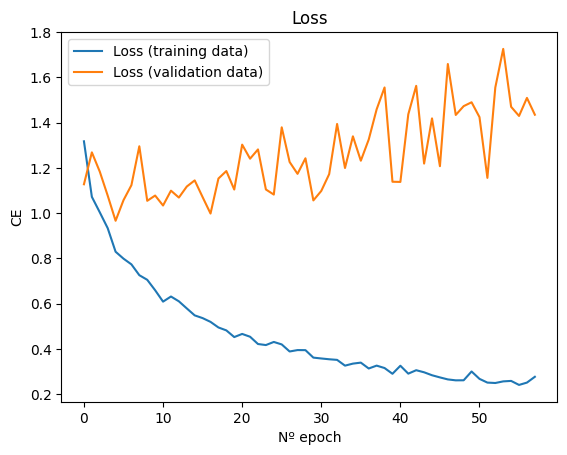

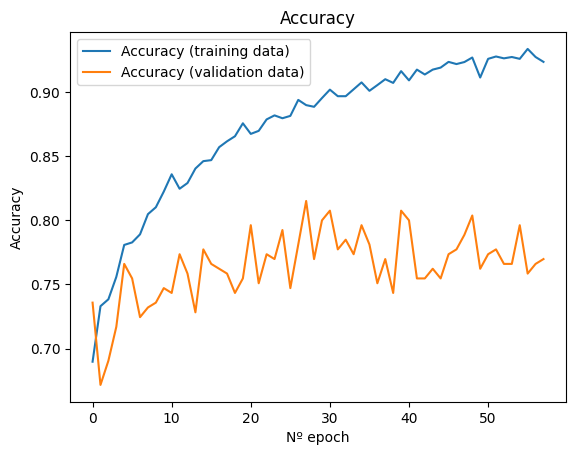

In [ ]:
model_ft.compile(optimizer= 'adam', loss='categorical_crossentropy', metrics=['accuracy'])
h = model_ft.fit(train_dataset_ffd, validation_data=valid_dataset_ffd, epochs=EPOCHS, callbacks=[checkpoint, stop])

plot_and_save(h, path_csv, name)

#### STILL OVERFITTED, RE-TRAIN WITH MORE DATA AUGMENTATION

In [ ]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale= 1.0/255,
                                                                  rotation_range=10,
                                                                  horizontal_flip=True,
                                                                  vertical_flip=True,
                                                                  zoom_range=0.1,
                                                                  fill_mode='reflect',
                                                                  width_shift_range=0.1,
                                                                  shear_range=0.1,
                                                                  brightness_range=(0.95,1.05))


valid_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale= 1.0/255)
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale= 1.0/255)

train_path = DATA_PATH + 'train'
valid_path = DATA_PATH + 'valid'
test_path = DATA_PATH + 'test'

# Path to the directory
# Define sizes
# Declare classes as categorical
# Batch size = 16
# Train dataset should always have shuffle
train_dataset_ffd = train_generator.flow_from_directory(
    train_path,
    target_size= (SIZE,SIZE),
    class_mode= 'categorical',
    batch_size= 64,
    shuffle= True
                                                        )

# Valid and Test dataset don't need to be shuffled
valid_dataset_ffd = valid_generator.flow_from_directory(
    valid_path,
    target_size= (SIZE,SIZE),
    class_mode= 'categorical',
    batch_size= 64,
    shuffle= False
                                                        )

test_dataset_ffd = test_generator.flow_from_directory(
    test_path,
    target_size= (SIZE,SIZE),
    class_mode= 'categorical',
    batch_size= 64,
    shuffle= False
                                                    )

Found 7624 images belonging to 53 classes.
Found 265 images belonging to 53 classes.
Found 265 images belonging to 53 classes.


In [ ]:
name = 'Custom_3'

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    os.path.join(path_models, name + '.h5'),
    monitor= 'val_accuracy',
    verbose= 0,
    save_best_only= True,
    save_weights_only= False,
    mode= 'max',
    save_freq= 'epoch'
                                                )

stop = tf.keras.callbacks.EarlyStopping(
    monitor= 'val_accuracy',
    min_delta= 0.001,
    patience= PATIENCE_ES,
    verbose = 0,
    mode= 'max',
    baseline= None,
    restore_best_weights= True
                                                )

Epoch 1/100
477/477 [==============================] - 57s 118ms/step - loss: 1.3143 - accuracy: 0.6448 - val_loss: 1.3756 - val_accuracy: 0.6679
Epoch 2/100
477/477 [==============================] - 57s 119ms/step - loss: 1.1496 - accuracy: 0.6822 - val_loss: 1.1428 - val_accuracy: 0.7434
Epoch 3/100
477/477 [==============================] - 56s 117ms/step - loss: 1.0851 - accuracy: 0.7041 - val_loss: 1.1626 - val_accuracy: 0.6868
Epoch 4/100
477/477 [==============================] - 56s 117ms/step - loss: 1.0068 - accuracy: 0.7171 - val_loss: 1.1420 - val_accuracy: 0.7019
Epoch 5/100
477/477 [==============================] - 56s 118ms/step - loss: 0.9591 - accuracy: 0.7291 - val_loss: 1.1858 - val_accuracy: 0.7132
Epoch 6/100
477/477 [==============================] - 56s 117ms/step - loss: 0.9434 - accuracy: 0.7301 - val_loss: 1.2219 - val_accuracy: 0.7245
Epoch 7/100
477/477 [==============================] - 56s 117ms/step - loss: 0.9087 - accuracy: 0.7390 - val_loss: 1.0753 -

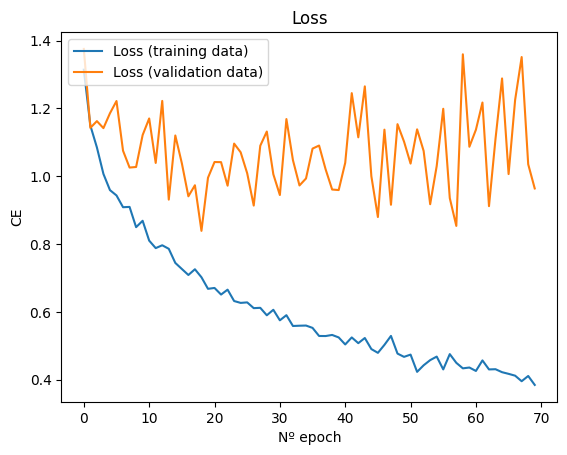

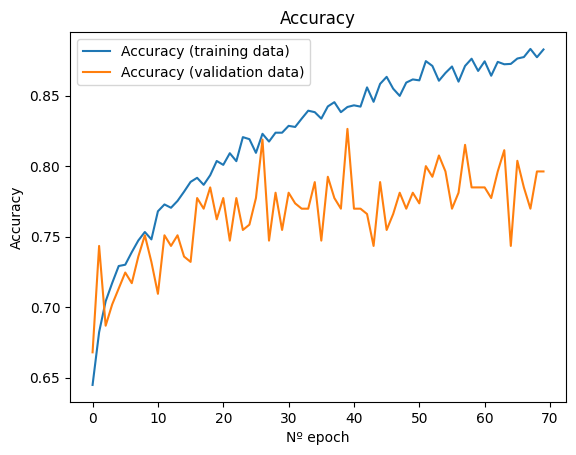

In [ ]:
model_ft2 = tf.keras.models.load_model('Models/Custom_2.h5')
model_ft2.compile(optimizer= 'adam', loss='categorical_crossentropy', metrics=['accuracy'])
h = model_ft2.fit(train_dataset_ffd, validation_data=valid_dataset_ffd, epochs=EPOCHS, callbacks=[checkpoint, stop])

plot_and_save(h, path_csv, name)

## Evaluation of fine tuning

In [ ]:
custom2 = tf.keras.models.load_model('Cards/Custom_2.h5')
custom3 = tf.keras.models.load_model('Models/Custom_3.h5')
transf2 = tf.keras.models.load_model('Models/ViT_B16_2.h5')
conv2 = tf.keras.models.load_model('Models/MobileNet_2.h5')

In [ ]:
_, conv_acc2 = conv2.evaluate(test_dataset_ffd)
_, transf_acc2 = transf2.evaluate(test_dataset_ffd)
_, custom_acc2 = custom2.evaluate(test_dataset_ffd)
_, custom_acc3 = custom3.evaluate(test_dataset_ffd)

17/17 [==============================] - 0s 18ms/step - loss: 1.6618 - accuracy: 0.7509


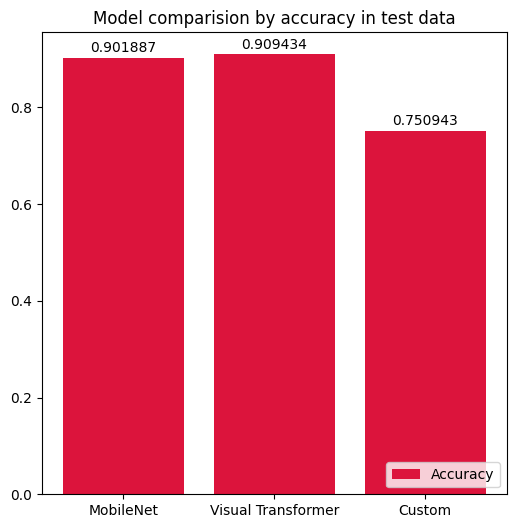

In [ ]:
fig = plt.figure(figsize=(6,6))

axis_x = ['MobileNet', 'Visual Transformer', 'Custom']

b = plt.bar(axis_x, [conv_acc2, transf_acc2, custom_acc3], color='crimson', label='Accuracy')
plt.bar_label(b, padding= 2)
plt.title('Model comparision by accuracy in test data')
plt.legend(loc = 'lower right')
plt.show()

### Classification report

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def show_report(model, dataframe):

  labels = dataframe.class_indices

  true_labels = dataframe.labels
  pred_labels = model.predict(dataframe, verbose=0).argmax(axis=1)

  keys_array = np.array(list(labels.keys()))

  true_text = [keys_array[value] for value in true_labels]
  pred_text = [keys_array[value] for value in pred_labels]

  print(classification_report(true_text, pred_text))


def show_matrix(model, dataframe):

  labels = dataframe.class_indices

  true_labels = dataframe.labels
  pred_labels = model.predict(dataframe, verbose=0).argmax(axis=1)

  keys_array = np.array(list(labels.keys()))

  true_text = [keys_array[value] for value in true_labels]
  pred_text = [keys_array[value] for value in pred_labels]

  cf = confusion_matrix(true_text, pred_text, labels= keys_array)

  fig, ax = plt.subplots(figsize=(12,12))
  sns.heatmap(cf, annot=True, fmt="", square=True, cbar=False,
              cmap=plt.cm.Blues, xticklabels=keys_array, yticklabels=keys_array, ax = ax)
  ax.set_ylabel('Actual')
  ax.set_xlabel('Predicted')
  ax.set_title('Confusion Matrix')
  plt.show()

In [ ]:
show_report(transf2, test_dataset_ffd)

                   precision    recall  f1-score   support

     ace of clubs       1.00      1.00      1.00         5
  ace of diamonds       1.00      1.00      1.00         5
    ace of hearts       1.00      1.00      1.00         5
    ace of spades       0.83      1.00      0.91         5
   eight of clubs       0.83      1.00      0.91         5
eight of diamonds       1.00      1.00      1.00         5
  eight of hearts       0.83      1.00      0.91         5
  eight of spades       0.83      1.00      0.91         5
    five of clubs       0.67      0.80      0.73         5
 five of diamonds       0.80      0.80      0.80         5
   five of hearts       0.83      1.00      0.91         5
   five of spades       0.83      1.00      0.91         5
    four of clubs       1.00      0.80      0.89         5
 four of diamonds       1.00      1.00      1.00         5
   four of hearts       1.00      1.00      1.00         5
   four of spades       1.00      0.80      0.89       

### Conf matrix

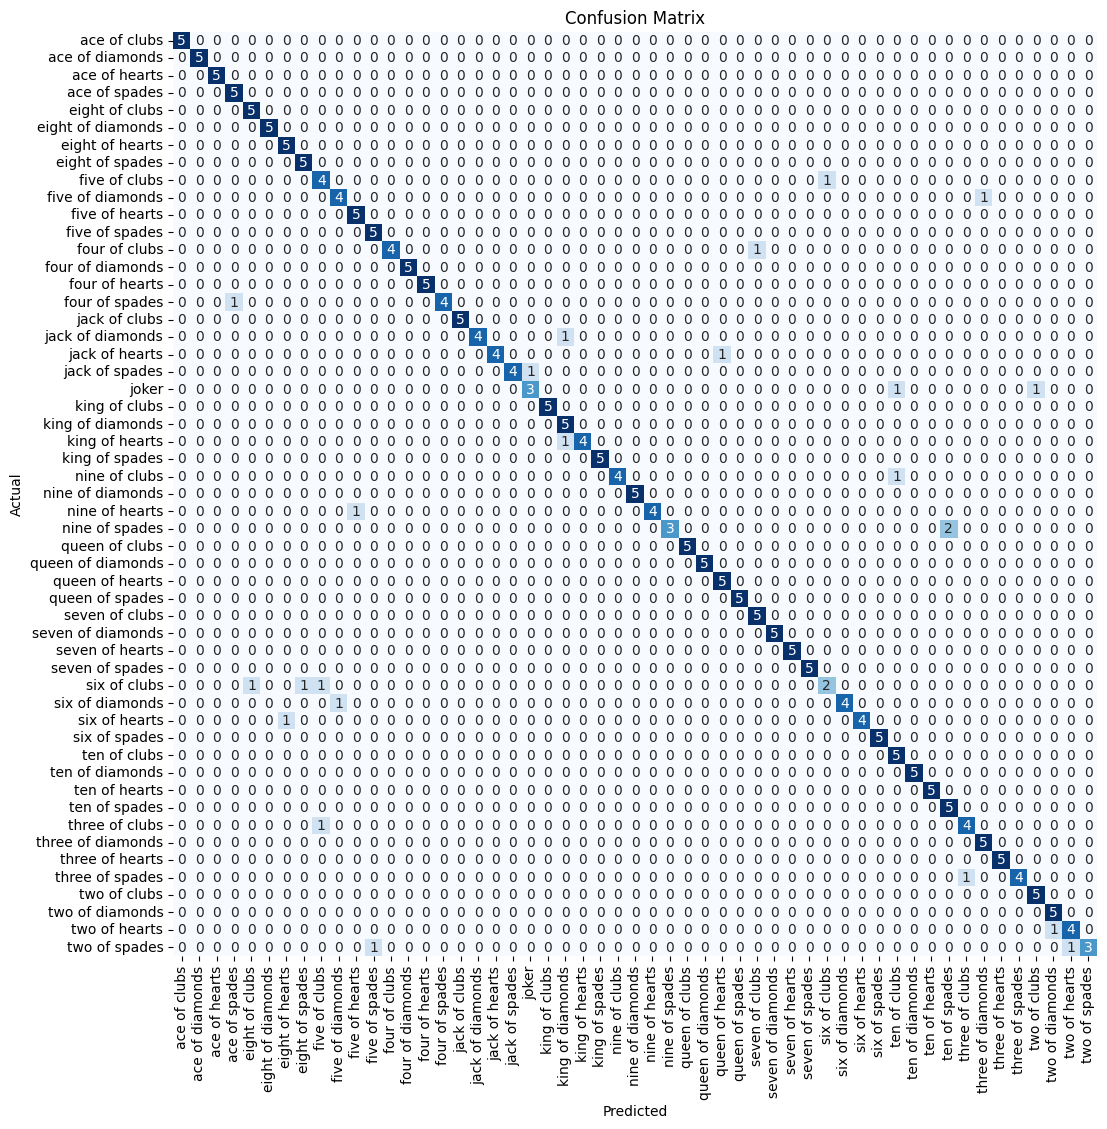

In [ ]:
show_matrix(transf2, test_dataset_ffd)

#Assignment

Objetivo: tratar de mejorar estos modelos

Grading: ranking proporcional al accuracy conseguido

Deadline:

Ideas:
- Ampliar la BD
- Usar los pesos y mejorar el DA, regularización, hiperparámetros, optimizadores, etc.
- Cambiar de arquitectura